<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit Submissions Classification Project

# Information

This projects covers the scraping of the Reddit APIs, Natural Language Processing, and classification machine learning models.

The purpose of this project is to train the models to predict which subreddit a submission belongs to: r/coffee or r/tea.

This is the second notebook of this project.

# Background

I am part of the data science team working in a beverage company, Coftea, specializing in coffee and tea products. With the rise of numerous e-commerce platforms and numerous competitors in this space, it is important that the decisions made are founded on data in order to standout from the crowd.

# Problem Statement

To optimize our marketing expenditure, we would like to target our advertisements to people who are most likely going to buy our products. A good proxy would be their past search results. Also, buzz in the forums would give us a good indication of upcoming and fading trends so that we are more informed of our R&D focus and stock re-filling. My team and I are presenting to fellow colleagues and management who are non-technical, to share our findings on a recent project to build a classification model for the company that would be the foundation of this optimization.

With our classification models, we will be able to identify the types of tea leaves or coffee beans, machinery, and even derivative products (such as pastry) to stock up so that Coftea can capture the rising demand.

Since we are looking to advertise to consumers who have shown some indication of interest in certain products (through the proxy of posting on sites such as subreddit), we will use accuracy as the primary metric.

# Importing libraries

In [179]:
# Usual libraries
import pandas as pd
import numpy as np

# For webscraping
import requests
import time


# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# For NLP cleaning and preprocessing
import demoji
import re, string, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import pickle

# Importing dataset

In [27]:
df = pd.read_csv('../data/data.csv')

In [28]:
df.head()

,subreddit,text
0,1,make taste refreshingi love especially green j...
1,1,best strawberry kombucha delicious probiotic b...
2,1,traditional medicinals worth buying
3,1,yall like dislike spout deal breaker
4,1,first flush experience goodhi recently get spe...


In [29]:
# Splitting into X and y
X = df['text']
y = df['subreddit']

# Train/Test Split

In [30]:
# Dividing the entire dataset into a train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

# Baseline Score

In [31]:
# Without using any model and looking at the counts, we can get the baseline accuracy
y_test.value_counts(normalize = True)

0    0.516129
1    0.483871
Name: subreddit, dtype: float64

##### The baseline score can be determined to be at ~50%

# Modelling

## Multinomial Naive Bayes Model (CountVectorizer)

In [32]:
# Setting up a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_cvec_multinomial = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [33]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000, 6000
# Minimum number of documents needed to include token: 2, 3, 4, 5, 6, 7
# Maximum number of documents needed to include token: 80%, 85%, 90%, 95%
# Check unigrams, bigrams, and trigrams
# Regularization strength: 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100

pipe_cvec_multinomial_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000, 6_000],
    'cvec__min_df': [2, 3, 4, 5, 6, 7] , 
    'cvec__max_df': [0.8, 0.85, 0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'nb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]
}

In [34]:
# Instantiate GridSearchCV.
cvec_multinomial = GridSearchCV(pipe_cvec_multinomial,
                   param_grid = pipe_cvec_multinomial_params,
                   cv = 5,
                   n_jobs = -1,
                   verbose = 2) 

In [35]:
%%time
# Conducting GridSearch on training data
cvec_multinomial.fit(X_train, y_train);

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
CPU times: total: 1min 16s
Wall time: 48min 19s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85, 0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4, 5, 6, 7],
                         'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'nb__alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100]},
             verbose=2)

In [36]:
# Retrieving the best parameters resulting from the GridSearch
print(cvec_multinomial.best_params_)

{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.1}


In [37]:
# Best score
cvec_multinomial_best = round(cvec_multinomial.best_score_, 5)
print('CountVectorizer Multinomial Naive Bayes GridSearchCV best score is:{}.'.format(cvec_multinomial_best))

# Training score
cvec_multinomial_train = round(cvec_multinomial.score(X_train, y_train), 5)
print('CountVectorizer Multinomial Naive Bayes train score is:{}.'.format(cvec_multinomial_train))

# Test score
cvec_multinomial_test = round(cvec_multinomial.score(X_test, y_test), 5)
print('CountVectorizer Multinomial Naive Bayes test score is:{}.'.format(cvec_multinomial_test))

CountVectorizer Multinomial Naive Bayes GridSearchCV best score is:0.86244.
CountVectorizer Multinomial Naive Bayes train score is:0.93882.
CountVectorizer Multinomial Naive Bayes test score is:0.87542.


D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


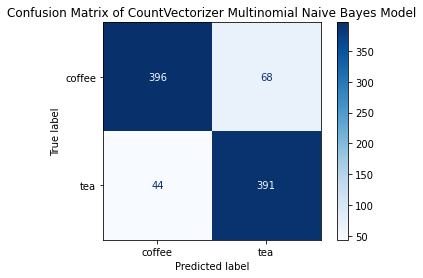

In [38]:
# View confusion matrix
plot_confusion_matrix(cvec_multinomial, X_test, y_test, cmap='Blues', values_format='d', display_labels=['coffee', 'tea'])
plt.title('Confusion Matrix of CountVectorizer Multinomial Naive Bayes Model');

D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


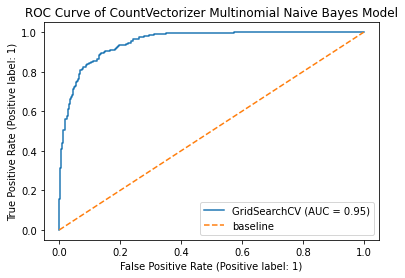

In [39]:
# Plotting AUC ROC curve
plot_roc_curve(cvec_multinomial, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()
plt.title('ROC Curve of CountVectorizer Multinomial Naive Bayes Model');

## Bernoulli Naive Bayes Model (CountVectorizer)

In [40]:
# Setting up a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Bernoulli Naive Bayes (estimator)

pipe_cvec_bernoulli = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', BernoulliNB())
])

In [41]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000, 6000
# Minimum number of documents needed to include token: 2, 3, 4, 5, 6, 7
# Maximum number of documents needed to include token: 80%, 85%, 90%, 95%
# Check unigrams, bigrams, and trigrams
# Regularization strength: 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100

pipe_cvec_bernoulli_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000, 6_000],
    'cvec__min_df': [2, 3, 4, 5, 6, 7] , 
    'cvec__max_df': [0.8, 0.85, 0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'nb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]
}

In [42]:
# Instantiate GridSearchCV
cvec_bernoulli = GridSearchCV(pipe_cvec_bernoulli, 
                              param_grid = pipe_cvec_bernoulli_params,
                              cv = 5,
                              n_jobs = -1,
                              verbose = 2) 

In [43]:
%%time
# Conducting GridSearch on training data
cvec_bernoulli.fit(X_train, y_train)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
CPU times: total: 1min 14s
Wall time: 48min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85, 0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4, 5, 6, 7],
                         'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'nb__alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100]},
             verbose=2)

In [44]:
# Retrieving the best parameters resulting from the GridSearch
print(cvec_bernoulli.best_params_)

{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.0001}


In [45]:
# Best score
cvec_bernoulli_best = round(cvec_bernoulli.best_score_, 5)
print('CountVectorizer Bernoulli Naive Bayes GridSearchCV best score is:{}.'.format(cvec_bernoulli_best))

# Training score
cvec_bernoulli_train = round(cvec_bernoulli.score(X_train, y_train), 5)
print('CountVectorizer Bernoulli Naive Bayes train score is:{}.'.format(cvec_bernoulli_train))

# Test score
cvec_bernoulli_test = round(cvec_bernoulli.score(X_test, y_test), 5)
print('CountVectorizer Bernoulli Naive Bayes test score is:{}.'.format(cvec_bernoulli_test))

CountVectorizer Bernoulli Naive Bayes GridSearchCV best score is:0.81238.
CountVectorizer Bernoulli Naive Bayes train score is:0.89618.
CountVectorizer Bernoulli Naive Bayes test score is:0.82091.


D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


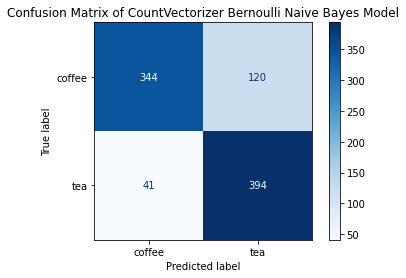

In [46]:
# View confusion matrix
plot_confusion_matrix(cvec_bernoulli, X_test, y_test, cmap='Blues', values_format='d', display_labels=['coffee', 'tea'])
plt.title('Confusion Matrix of CountVectorizer Bernoulli Naive Bayes Model');

D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


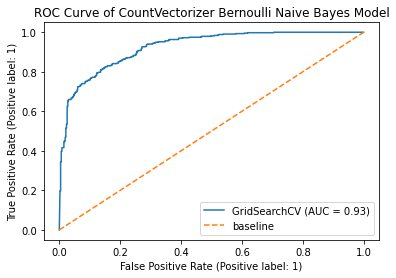

In [47]:
# Plotting AUC ROC curve
plot_roc_curve(cvec_bernoulli, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()
plt.title('ROC Curve of CountVectorizer Bernoulli Naive Bayes Model');

## Multinomial Naive Bayes Model (TF-IDF)

In [48]:
# Setting up a pipeline up with two stages:
# 1. Term Frequency-Inverse Document Frequency (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec_multinomial = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [49]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000, 6000
# Minimum number of documents needed to include token: 2, 3, 4, 5, 6, 7
# Maximum number of documents needed to include token: 80%, 85%, 90%, 95%
# Check unigrams, bigrams, and trigrams
# Regularization strength: 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100

pipe_tvec_multinomial_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000, 6_000],
    'tvec__min_df': [2, 3, 4, 5, 6, 7] , 
    'tvec__max_df': [0.8, 0.85, 0.9, 0.95],
    'tvec__ngram_range': [(1,1), (2,2), (3,3)],
    'nb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]
}

In [50]:
# Instantiate GridSearchCV
tvec_multinomial = GridSearchCV(pipe_tvec_multinomial,
                                param_grid = pipe_tvec_multinomial_params,
                                cv = 5,
                                n_jobs = -1,
                                verbose = 2) 

In [51]:
%%time
# Conducting GridSearch on training data
tvec_multinomial.fit(X_train, y_train)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
CPU times: total: 1min 11s
Wall time: 36min 21s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100],
                         'tvec__max_df': [0.8, 0.85, 0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'tvec__min_df': [2, 3, 4, 5, 6, 7],
                         'tvec__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             verbose=2)

In [52]:
# Retrieving the best parameters resulting from the GridSearch
print(tvec_multinomial.best_params_)

{'nb__alpha': 0.1, 'tvec__max_df': 0.8, 'tvec__max_features': 3000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}


In [53]:
# Best score
tvec_multinomial_best = round(tvec_multinomial.best_score_, 5)
print('TFIDF Multinomial Naive Bayes GridSearchCV best score is:{}.'.format(tvec_multinomial_best))

# Training score
tvec_multinomial_train = round(tvec_multinomial.score(X_train, y_train), 5)
print('TFIDF Multinomial Naive Bayes train score is:{}.'.format(tvec_multinomial_train))

# Test score
tvec_multinomial_test = round(tvec_multinomial.score(X_test, y_test), 5)
print('TFIDF Multinomial Naive Bayes test score is:{}.'.format(tvec_multinomial_test))

TFIDF Multinomial Naive Bayes GridSearchCV best score is:0.85836.
TFIDF Multinomial Naive Bayes train score is:0.94624.
TFIDF Multinomial Naive Bayes test score is:0.87653.


D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


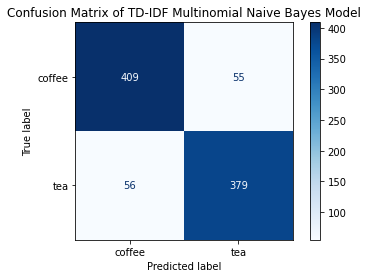

In [54]:
# View confusion matrix
plot_confusion_matrix(tvec_multinomial, X_test, y_test, cmap='Blues', values_format='d', display_labels=['coffee', 'tea'])
plt.title('Confusion Matrix of TD-IDF Multinomial Naive Bayes Model');

D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


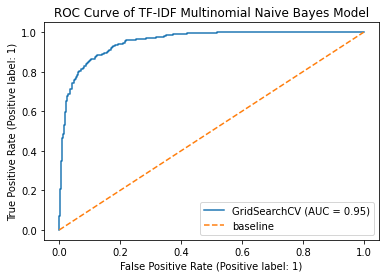

In [55]:
# Plotting AUC ROC curve
plot_roc_curve(tvec_multinomial, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()
plt.title('ROC Curve of TF-IDF Multinomial Naive Bayes Model');

## Bernoulli Naive Bayes Model (TF-IDF)

In [56]:
# Setting up a pipeline up with two stages:
# 1. Term Frequency-Inverse Document Frequency (transformer)
# 2. Bernoulli Naive Bayes (estimator)

pipe_tvec_bernoulli = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', BernoulliNB())
])

In [57]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000, 6000
# Minimum number of documents needed to include token: 2, 3, 4, 5, 6, 7
# Maximum number of documents needed to include token: 80%, 85%, 90%, 95%
# Check unigrams, bigrams, and trigrams
# Regularization strength: 0.00001, 0.0001, 0.001, 0.1, 1, 10, 100

pipe_tvec_bernoulli_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000, 6_000],
    'tvec__min_df': [2, 3, 4, 5, 6, 7] , 
    'tvec__max_df': [0.8, 0.85, 0.9, 0.95],
    'tvec__ngram_range': [(1,1), (2,2), (3,3)],
    'nb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]
}

In [58]:
# Instantiate GridSearchCV.
tvec_bernoulli = GridSearchCV(pipe_tvec_bernoulli,
                              param_grid = pipe_tvec_bernoulli_params,
                              cv = 5,
                              n_jobs = -1,
                              verbose = 2)

In [59]:
%%time
# Fit GridSearch to training data.
tvec_bernoulli.fit(X_train, y_train)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
CPU times: total: 1min 10s
Wall time: 30min 11s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100],
                         'tvec__max_df': [0.8, 0.85, 0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'tvec__min_df': [2, 3, 4, 5, 6, 7],
                         'tvec__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             verbose=2)

In [60]:
# Retrieving the best parameters resulting from the GridSearch
print(tvec_bernoulli.best_params_)

{'nb__alpha': 0.0001, 'tvec__max_df': 0.8, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [61]:
# Best score
tvec_bernoulli_best = round(tvec_bernoulli.best_score_, 5)
print('TFIDF Bernoulli Naive Bayes GridSearch CV best score is:{}.'.format(tvec_bernoulli_best))

# Training score
tvec_bernoulli_train = round(tvec_bernoulli.score(X_train, y_train), 5)
print('TFIDF Bernoulli Naive Bayes train score is:{}.'.format(tvec_bernoulli_train))

# Test score
tvec_bernoulli_test = round(tvec_bernoulli.score(X_test, y_test), 5)
print('TFIDF Bernoulli Naive Bayes test score is:{}.'.format(tvec_bernoulli_test))

TFIDF Bernoulli Naive Bayes GridSearch CV best score is:0.81238.
TFIDF Bernoulli Naive Bayes train score is:0.89618.
TFIDF Bernoulli Naive Bayes test score is:0.82091.


D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


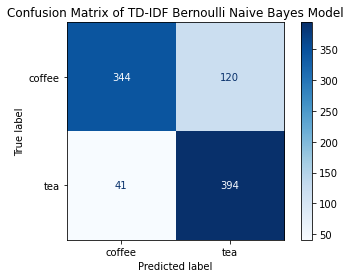

In [62]:
# View confusion matrix
plot_confusion_matrix(tvec_bernoulli, X_test, y_test, cmap='Blues', values_format='d', display_labels=['coffee', 'tea'])
plt.title('Confusion Matrix of TD-IDF Bernoulli Naive Bayes Model');

D:\Anaconda\envs\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


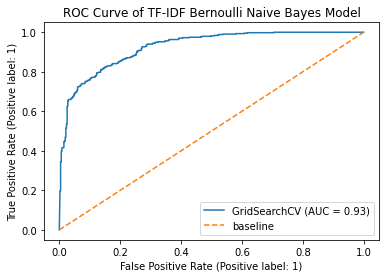

In [63]:
# Plotting AUC ROC Curve
plot_roc_curve(tvec_bernoulli, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()
plt.title('ROC Curve of TF-IDF Bernoulli Naive Bayes Model');

##  Random Forest (CountVectorizer)

In [64]:
# Instantiate RandomForestClassifier
rf = RandomForestClassifier()

In [65]:
# Setting up a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Random Forest (estimator)

pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

In [71]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000, 6000
# Minimum number of documents needed to include token: 2, 3, 4, 5, 6
# Maximum number of documents needed to include token: 80%, 85%, 90%, 95%
# Check unigrams, bigrams, and trigrams
# Number of trees in the forest: 30, 50, 70, 90, 110, 130

pipe_cvec_rf_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000, 6_000],
    'cvec__min_df': [2, 3, 4, 5, 6] , 
    'cvec__max_df': [0.8, 0.85, 0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'rf__n_estimators': [30, 50, 70, 90, 110, 130],
}

In [72]:
# Instantiate GridSearchCV.
cvec_rf = GridSearchCV(pipe_cvec_rf,
                       param_grid = pipe_cvec_rf_params,
                       cv = 5,
                       n_jobs = -1,
                       verbose = 2)

In [73]:
%%time
# Conducting GridSearch on training data
cvec_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
CPU times: total: 55.8 s
Wall time: 1h 16min 1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85, 0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4, 5, 6],
                         'cvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
                         'rf__n_estimators': [30, 50, 70, 90, 110, 130]},
             verbose=2)

In [74]:
# Retrieving the best parameters resulting from the GridSearch
print(cvec_rf.best_params_)

{'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'rf__n_estimators': 90}


In [75]:
# Best score
cvec_rf_best = round(cvec_rf.best_score_, 5)
print('CountVectorizer Random Forest GridSearchCV best score is:{}.'.format(cvec_rf_best))

# Training score
cvec_rf_train = round(cvec_rf.score(X_train, y_train), 5)
print('CountVectorizer Random Forest train score is:{}.'.format(cvec_rf_train))

# Test score
cvec_rf_test = round(cvec_rf.score(X_test, y_test), 5)
print('CountVectorizer Random Forest test score is:{}.'.format(cvec_rf_test))

CountVectorizer Random Forest GridSearchCV best score is:0.82017.
CountVectorizer Random Forest train score is:0.99629.
CountVectorizer Random Forest test score is:0.83982.


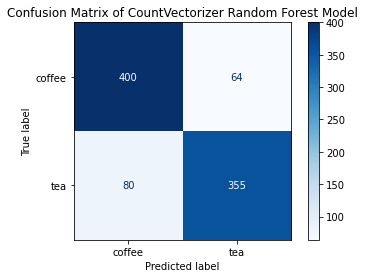

In [76]:
# View confusion matrix
plot_confusion_matrix(cvec_rf, X_test, y_test, cmap='Blues', values_format='d', display_labels=['coffee', 'tea'])
plt.title('Confusion Matrix of CountVectorizer Random Forest Model');

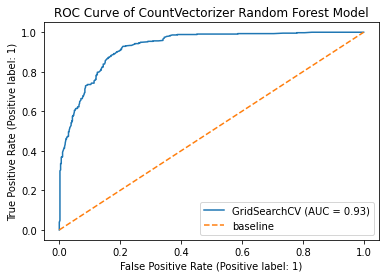

In [77]:
# Plotting AUC ROC Curve
plot_roc_curve(cvec_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()
plt.title('ROC Curve of CountVectorizer Random Forest Model');

## Random Forest (TF-IDF)

In [78]:
# Setting up a pipeline up with two stages:
# 1. Term Frequency-Inverse Document Frequency (transformer)
# 2. Random Forest (estimator)

pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

In [83]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000, 6000
# Minimum number of documents needed to include token: 2, 3, 4, 5, 6
# Maximum number of documents needed to include token: 80%, 85%, 90%, 95%
# Check unigrams, bigrams, and trigrams
# Number of trees in the forest: 30, 50, 70, 90, 110, 130

pipe_tvec_rf_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000, 6_000],
    'tvec__min_df': [2, 3, 4, 5, 6] , 
    'tvec__max_df': [0.8, 0.85, 0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'rf__n_estimators': [30, 50, 70, 90, 110, 130],
}

In [84]:
# Instantiate GridSearchCV.
tvec_rf = GridSearchCV(pipe_tvec_rf,
                       param_grid = pipe_tvec_rf_params,
                       cv = 5,
                       n_jobs = -1,
                       verbose = 2)

In [85]:
%%time
# Conducting GridSearch on training data
tvec_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
CPU times: total: 55.5 s
Wall time: 1h 10min 25s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__n_estimators': [30, 50, 70, 90, 110, 130],
                         'tvec__max_df': [0.8, 0.85, 0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'tvec__min_df': [2, 3, 4, 5, 6],
                         'tvec__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             verbose=2)

In [90]:
# Best score
tvec_rf_best = round(tvec_rf.best_score_, 5)
print('TF-IDF Random Forest GridSearchCV best score is:{}.'.format(tvec_rf_best))

# Training score
tvec_rf_train = round(tvec_rf.score(X_train, y_train), 5)
print('TF-IDF Random Forest train score is:{}.'.format(tvec_rf_train))

# Test score
tvec_rf_test = round(tvec_rf.score(X_test, y_test), 5)
print('TF-IDF Random Forest test score is:{}.'.format(tcvec_rf_test))

TF-IDF Random Forest GridSearchCV best score is:0.81942.
TF-IDF Random Forest train score is:0.99778.
TF-IDF Random Forest test score is:0.8287.


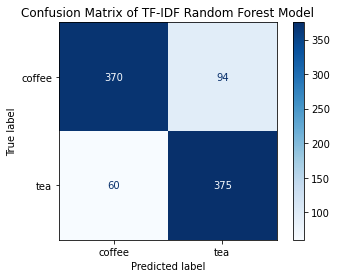

In [87]:
# View confusion matrix
plot_confusion_matrix(tvec_rf, X_test, y_test, cmap='Blues', values_format='d', display_labels=['coffee', 'tea'])
plt.title('Confusion Matrix of TF-IDF Random Forest Model');

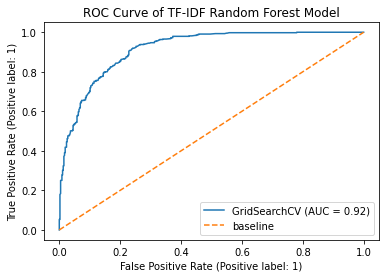

In [88]:
# Plotting AUC ROC Curve
plot_roc_curve(tvec_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend()
plt.title('ROC Curve of TF-IDF Random Forest Model');

# Summary of Results

The scores shown here are accuracy scores.

In [166]:
models = ['CountVectorizer Multinomial NB', 'CountVectorizer Bernoulli NB','TF-IDF Multinomial NB','TF-IDF Bernoulli NB',
          'CountVectorizer Random Forest', 'TF-IDF Random Forest', 'Baseline']


gs_best_score = [cvec_multinomial_best, cvec_bernoulli_best, tvec_multinomial_best, tvec_bernoulli_best,
                 cvec_rf_best, tvec_rf_best, 0.5]

train_score = [cvec_multinomial_train, cvec_bernoulli_train, tvec_multinomial_train, tvec_bernoulli_train,
                 cvec_rf_train, tvec_rf_train, 0.5]

test_score = [cvec_multinomial_test, cvec_bernoulli_test, tvec_multinomial_test, tvec_bernoulli_test,
                 cvec_rf_test, tvec_rf_test, 0.5]

score_summary = pd.DataFrame(data = [models, gs_best_score, train_score, test_score],
                             index = ['Model', 'GridSearch Best Accuracy', 'Train Accuracy', 'Test Accuracy'])

In [167]:
# Transposing the table
score_summary = score_summary.T

In [168]:
# Ordering the rows based on decreasing test accuracy
score_summary = score_summary.sort_values(by = 'Test Accuracy', ascending = False)
score_summary

,Model,GridSearch Best Accuracy,Train Accuracy,Test Accuracy
2,TF-IDF Multinomial NB,0.85836,0.94624,0.87653
0,CountVectorizer Multinomial NB,0.86244,0.93882,0.87542
4,CountVectorizer Random Forest,0.82017,0.99629,0.83982
5,TF-IDF Random Forest,0.81942,0.99778,0.8287
1,CountVectorizer Bernoulli NB,0.81238,0.89618,0.82091
3,TF-IDF Bernoulli NB,0.81238,0.89618,0.82091
6,Baseline,0.5,0.5,0.5


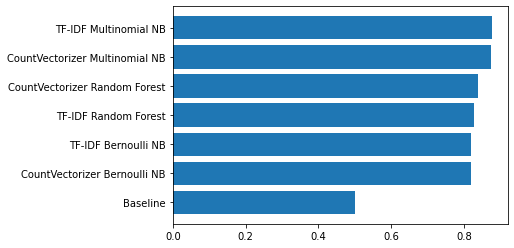

In [169]:
# Plotting test accuracy scores
score_summary = score_summary.sort_values(by = 'Test Accuracy', ascending = True)
plt.barh('Model', 'Test Accuracy', data = score_summary);

Based on test accuracy, the TF-IDF Multinomial Naive Bayes Model performs the best and shall be the chosen model used for production.

# Top Predictor Words

In [170]:
# Saving the estimator of the best model
best_model_est = tvec_multinomial.best_estimator_

In [171]:
# Saving variables for better accessibility
transformer = best_model_est.named_steps['tvec']
estimator = best_model_est.named_steps['nb']

In [173]:
# Storing feature name and difference in log probabilities between the 2 classes in a newly created dataframe
df = pd.DataFrame()
df['feature'] = transformer.get_feature_names()
df['log_prob_diff'] = estimator.feature_log_prob_[1,:] - estimator.feature_log_prob_[0,:]

In [174]:
# Following are the top 10 predictor words for tea
top_word_tea = df.sort_values(by = ['log_prob_diff'], ascending = False).head(10)
top_word_tea

,feature,log_prob_diff
1767,oolong,5.772123
1229,herbal,5.150556
1987,puerh,5.022959
1641,mint,4.884234
2768,white2tea,4.856714
480,chamomile,4.727288
1095,gaiwan,4.657410
841,earl,4.609453
1158,grey,4.599161
2510,teapot,4.573924


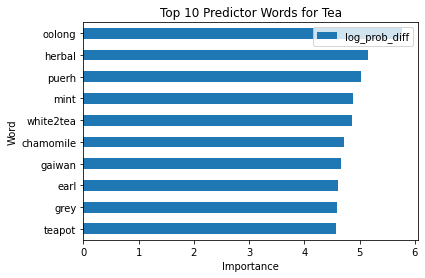

In [176]:
# Plotting top predictor words with respective differences in log probability 
top_word_tea = df.sort_values(by = ['log_prob_diff'], ascending = True).tail(10)
top_word_tea.plot.barh(y = 'log_prob_diff', x = 'feature')
plt.title('Top 10 Predictor Words for Tea')
plt.xlabel('Importance')
plt.ylabel('Word');

In [178]:
# Following are the top 10 predictor words for coffee
top_word_coffee = df.sort_values(by = ['log_prob_diff'], ascending = False).tail(10)
top_word_coffee

,feature,log_prob_diff
2569,timemore,-4.112298
373,breville,-4.144637
282,barista,-4.221270
1543,machine,-4.306598
2137,roaster,-4.383248
2686,v60,-4.517613
406,burr,-4.763168
898,espresso,-5.115763
1159,grind,-5.383926
1160,grinder,-5.688587


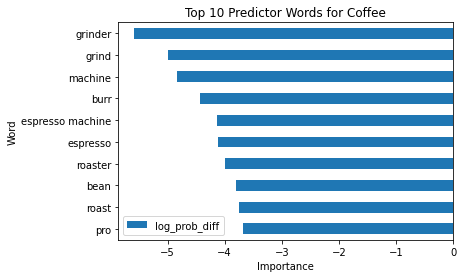

In [148]:
# Plotting top predictor words with respective differences in log probability 
top_word_coffee = df_.sort_values(by = ['log_prob_diff'], ascending = True).tail(10)
top_word_coffee.plot.barh(y = 'log_prob_diff', x = 'feature')
plt.title('Top 10 Predictor Words for Coffee')
plt.xlabel('Importance')
plt.ylabel('Word');

# Saving Best Model

In [182]:
# Saving model
pickle.dump(tvec_multinomial, open("../data/tvec_multinomial.pkl", "wb"))